In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import optuna
import time
import numpy as np

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Used device: {device}")

Used device: mps


In [4]:
df = pd.read_csv("movies_dataset.csv")
x = df[["user_id", "movie_id"]]
y = df["rating"]

X_f, X_test, y_f, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_f, y_f, test_size=0.12, random_state=42
)

### Baseline - average of ratings

In [5]:
average_rating = df["rating"].mean()
y_pred_baseline = [average_rating] * len(y_test)
baseline_mse = mean_squared_error(y_test, y_pred_baseline)

print(f"Ratings average global: {average_rating:.2f}")
print(f"Baseline mse: {baseline_mse:.4f}")

Ratings average global: 3.50
Baseline mse: 1.1329


### Neural Network

using pytorch Dataset to create custom dataset for neural network and DataLoaders

In [6]:
class MovieDataset(Dataset):
    def __init__(self, df, targets):
        self.users = torch.tensor(df["user_id"].values, dtype=torch.long)
        self.movies = torch.tensor(df["movie_id"].values, dtype=torch.long)
        self.ratings = torch.tensor(targets.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, index):
        return self.users[index], self.movies[index], self.ratings[index]

In [7]:
train_set = MovieDataset(X_train, y_train)
valid_set = MovieDataset(X_valid, y_valid)
test_set = MovieDataset(X_test, y_test)

In [8]:
BATCH_SIZE = 1024
torch.manual_seed(42)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    pin_memory=True
)

valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, pin_memory=True)

Model architecture

In [9]:
class Recommender(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=32, dropout_rate=0.4):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        self.user_bias = nn.Embedding(n_users, 1)
        self.movie_bias = nn.Embedding(n_movies, 1)
        
        self.global_bias = nn.Parameter(torch.zeros(1))

        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.movie_embedding.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)
    
    def forward(self, user, movie):
        user_vector = self.user_embedding(user)
        movie_vector = self.movie_embedding(movie)
        
        dot_product = (user_vector * movie_vector).sum(dim=1)
        
        u_bias = self.user_bias(user).squeeze()
        m_bias = self.movie_bias(movie).squeeze()
        
        prediction = dot_product + u_bias + m_bias + self.global_bias
        return prediction

In [10]:
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()

train model and find hyperparameters using optuna

In [11]:
def objective(trial):
    emb_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64, 128])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = Recommender(n_users, n_movies, emb_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    n_epochs = 5

    for epoch in range(n_epochs):
        model.train()
        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            optimizer.zero_grad()
            pred = model(users, movies)
            loss = criterion(pred, ratings)
            loss.backward()
            optimizer.step()
        
        model.eval()
        valid_mse = 0
        with torch.inference_mode():
            for users, movies, ratings in valid_loader:
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                preds = model(users, movies)
                valid_mse += criterion(preds, ratings).item()
        
        avg_valid_mse = valid_mse / len(valid_loader)

        trial.report(avg_valid_mse, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return avg_valid_mse

In [12]:
torch.manual_seed(42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    direction="minimize",
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=30)

[I 2026-02-11 10:59:52,811] A new study created in memory with name: no-name-d03e7460-ca29-435b-bfbd-a0a737e8375b
[I 2026-02-11 11:00:20,060] Trial 0 finished with value: 3.6185248923301696 and parameters: {'embedding_dim': 32, 'lr': 0.0002051338263087451}. Best is trial 0 with value: 3.6185248923301696.
[I 2026-02-11 11:00:56,110] Trial 1 finished with value: 0.8859599536657333 and parameters: {'embedding_dim': 64, 'lr': 0.0026070247583707684}. Best is trial 1 with value: 0.8859599536657333.
[I 2026-02-11 11:01:20,294] Trial 2 finished with value: 3.127015151977539 and parameters: {'embedding_dim': 32, 'lr': 0.0002310201887845295}. Best is trial 1 with value: 0.8859599536657333.
[I 2026-02-11 11:01:55,893] Trial 3 finished with value: 1.8685920941829681 and parameters: {'embedding_dim': 64, 'lr': 0.0003823475224675188}. Best is trial 1 with value: 0.8859599536657333.
[I 2026-02-11 11:02:19,622] Trial 4 finished with value: 1.1637835276126862 and parameters: {'embedding_dim': 16, 'lr':

### Train model more thouroughly on the best params found

In [13]:
# evaluate model function

def evaluate_tm(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    with torch.inference_mode():
        for users, movies, ratings in data_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            y_pred = model(users, movies)
            loss = loss_fn(y_pred, ratings)
            total_loss += loss.item()
    
    return total_loss / len(data_loader)

In [14]:
# training loop

def train_with_early_stopping(model, optimizer, loss_fn, train_loader,
                              valid_loader, n_epochs, patience=10):
    history = {"train_losses": [], "valid_losses": []}
    best_valid_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        total_loss = 0.0
        model.train()
        t0 = time.time()

        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            optimizer.zero_grad()
            y_pred = model(users, movies)
            loss = loss_fn(y_pred, ratings)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_valid_loss = evaluate_tm(model, valid_loader, loss_fn)

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), "best_model_tmp.pth")
            best = " (best)"
            patience_counter = 0
        else:
            patience_counter += 1
            best = ""
        
        t1 = time.time()
        history["train_losses"].append(avg_train_loss)
        history["valid_losses"].append(avg_valid_loss)

        print(f"Epoch {epoch + 1}/{n_epochs} | "
              f"Train MSE: {avg_train_loss:.4f} | "
              f"Valid MSE: {avg_valid_loss:.4f}{best} | "
              f"Time: {t1 - t0:.1f}s")

        if patience_counter >= patience:
            print("Early stopping")
            model.load_state_dict(torch.load("best_model_tmp.pth", weights_only=True))
            break
    
    return history

In [15]:
def plot_train_valid_loss(history):
    epochs = range(1, len(history["train_losses"]) + 1)
    plt.figure(figsize=(10, 7))
    plt.plot(epochs, history["train_losses"], "bo-", label="training")
    plt.plot(epochs, history["valid_losses"], "ro-", label="validation")

    plt.title("Training vs validation loss")
    plt.xlabel("epoch")
    plt.ylabel("loss value")
    plt.legend()
    plt.grid()
    plt.show()

In [17]:
params = study.best_params

print(f"Best learning rate: {params['lr']}")
print(f"Best embedding dimension: {params['embedding_dim']}")

Best learning rate: 0.006536264082965748
Best embedding dimension: 128


In [19]:
final_recommender = Recommender(
    n_users, n_movies,
    embedding_dim=params["embedding_dim"],
).to(device)

optimizer = torch.optim.Adam(final_recommender.parameters(), lr=params["lr"], weight_decay=1e-4)
criterion = nn.MSELoss()

In [20]:
torch.manual_seed(42)

n_epochs = 100
history = train_with_early_stopping(
    final_recommender, 
    optimizer,
    criterion,
    train_loader,
    valid_loader,
    n_epochs,
    patience=10
)

Epoch 1/100 | Train MSE: 3.0243 | Valid MSE: 1.0036 (best) | Time: 17.0s
Epoch 2/100 | Train MSE: 0.9104 | Valid MSE: 0.8981 (best) | Time: 15.2s
Epoch 3/100 | Train MSE: 0.8625 | Valid MSE: 0.8762 (best) | Time: 15.2s
Epoch 4/100 | Train MSE: 0.8491 | Valid MSE: 0.8687 (best) | Time: 15.0s
Epoch 5/100 | Train MSE: 0.8445 | Valid MSE: 0.8662 (best) | Time: 15.3s
Epoch 6/100 | Train MSE: 0.8432 | Valid MSE: 0.8648 (best) | Time: 17.2s
Epoch 7/100 | Train MSE: 0.8427 | Valid MSE: 0.8648 (best) | Time: 16.8s
Epoch 8/100 | Train MSE: 0.8424 | Valid MSE: 0.8652 | Time: 14.9s
Epoch 9/100 | Train MSE: 0.8425 | Valid MSE: 0.8651 | Time: 15.5s
Epoch 10/100 | Train MSE: 0.8426 | Valid MSE: 0.8652 | Time: 16.0s
Epoch 11/100 | Train MSE: 0.8426 | Valid MSE: 0.8642 (best) | Time: 16.3s
Epoch 12/100 | Train MSE: 0.8424 | Valid MSE: 0.8651 | Time: 17.1s
Epoch 13/100 | Train MSE: 0.8424 | Valid MSE: 0.8653 | Time: 15.5s
Epoch 14/100 | Train MSE: 0.8425 | Valid MSE: 0.8654 | Time: 14.9s
Epoch 15/100 | 

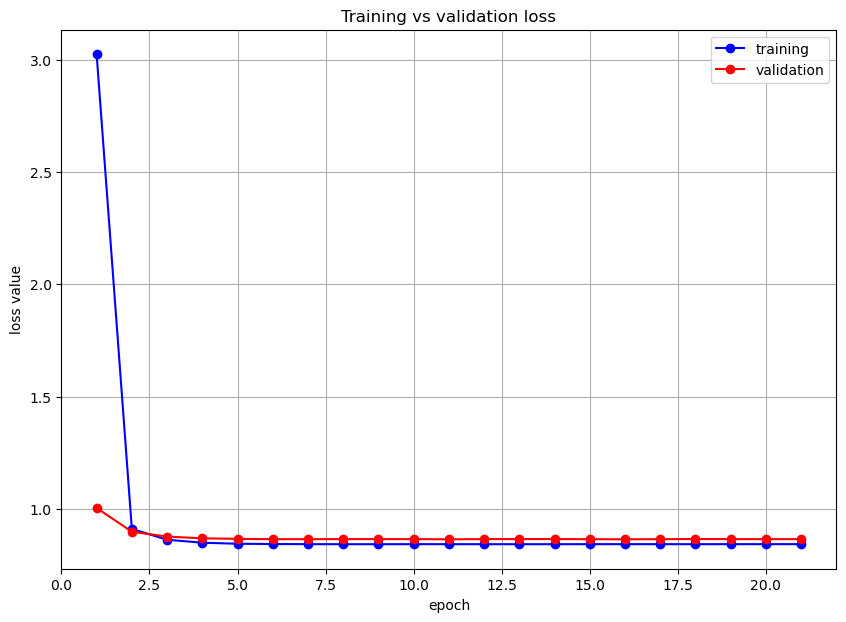

In [21]:
plot_train_valid_loss(history)

### Save final model and embeddings

In [22]:
torch.save(final_recommender.state_dict(), "best_model_th.pth")

movie_embd = final_recommender.movie_embedding.weight.detach().cpu().numpy()
np.save("movie_embeddings.npy", movie_embd)

all_movie_ids = sorted(df['movie_id'].unique())
np.save("movie_ids_map.npy", np.array(all_movie_ids))